In [2]:
import sys
sys.path.append('../')

import sys; sys.path.insert(0, '../../') ## make sure path to root of project directory
from wu_barcodes.config import *
from data.wu_data import *

import matplotlib as mpl
import matplotlib.pyplot as plt
import methods.ax_methods as ax_methods
mpl.rcParams.update(mpl_configs)
import numpy as np; rnd = np.random.default_rng()
import scipy.stats

In [3]:
import scipy.ndimage.filters as ndif
def running_mean_uniform_filter1d(x, N):
    return ndif.uniform_filter1d(x, N, mode='reflect', origin=0)

import methods.filter_lineages as fl

def calc_coarse_grained_lfc_array(freqs0, D0, freqs1, D1, dt, coarse_grain=100):
    cg_freqs0 = running_mean_uniform_filter1d(freqs0, coarse_grain)
    cg_freqs1 = running_mean_uniform_filter1d(freqs1, coarse_grain)

    cg_f0, cg_f1 = fl.maxmin_freqs(cg_freqs0, D0, cg_freqs1, D1)

    with np.errstate(divide='ignore'):
        return np.log( cg_f1/cg_f0 ) / dt


MEDIA = ['Arabinose', 'Glucose', 'TYG', 'WAX', 'Xylose']


def calc_coarse_grained_lfc_array2(freqs0, freqs1, dt, coarse_grain=100, pseudofreqs = (1e-7, 1e-7)):
    mask = np.array(freqs0)+np.array(freqs1) == 0

    pseudofreq_t0, pseudofreq_t1 = pseudofreqs
    masked_freqs0 = np.ma.masked_array(freqs0, mask) + pseudofreq_t0 #+ rnd.normal(loc=0, scale=pseudofreq_t0/10, size=mask.shape)
    masked_freqs1 = np.ma.masked_array(freqs1, mask) + pseudofreq_t1 #+ rnd.normal(loc=0, scale=pseudofreq_t1/10, size=mask.shape)

    cg_freqs0 = running_mean_uniform_filter1d(masked_freqs0, coarse_grain)
    cg_freqs1 = running_mean_uniform_filter1d(masked_freqs1, coarse_grain)

    with np.errstate(divide='ignore'):
        return np.log( cg_freqs1/cg_freqs0 ) / dt

/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:282: RuntimeWarning: divide by zero encountered in log
  return np.log( freqs1/freqs0 ) / dt
/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:282: RuntimeWarning: divide by zero encountered in log
  return np.log( freqs1/freqs0 ) / dt
/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:282: RuntimeWarning: divide by zero encountered in log
  return np.log( freqs1/freqs0 ) / dt
/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:282: RuntimeWarning: divide by zero encountered in log
  return np.log( freqs1/freqs0 ) / dt
/Users/daniel/Documents/GoodLab/wu_barcodes_clean/jupyter/biorxiv_plot_scripts/../../methods/filter_lineages.py:282: RuntimeWarning: divide by zero encountered in log
  return np.l

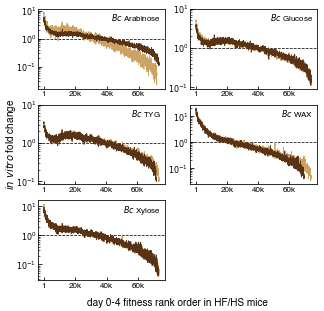

In [9]:

fig = plt.figure(figsize=(5, 5))
outer = mpl.gridspec.GridSpec(nrows=3, ncols=2, figure=fig)

outer_ax = fig.add_subplot(outer[:])
outer_ax.set_ylabel('$\it{in~vitro}$ fold change', fontsize=10, labelpad=10)
outer_ax.set_xlabel('day 0-4 fitness rank order in HF/HS mice', fontsize=10, labelpad=10)
ax_methods.turn_off_ax(outer_ax)

bac = 'BWH2'
if 'plot rank order curves, etc':
    min_reads = 5
    gene_nn = False
    cutoff = 10**-6.5
    cg = 100 #coarse_grain

    discovery_mice = [1, 2, 3, 5, 6, 7, 8, 9, 10]


    discovery_d0, discovery_d1 = 0, 4
    discovery_dt = discovery_d1 - discovery_d0
    validation_d0, validation_d1 = 0, 4
    validation_dt = validation_d1 - validation_d0

for m, medium in enumerate(MEDIA):
    ax_rank_order = fig.add_subplot(outer[m//2, m%2])
    for i, color in [(1, KELLY_COLORS[5]), (2, KELLY_COLORS[17])]:
        if 'generate discovery and validation frequencies':
                discovery_reads0, discovery_reads1 = np.copy(fl.get_read_arrays(bac, discovery_mice, discovery_d0, discovery_d1, split_day0=1))
                validation_reads0, _ = np.copy(fl.get_read_arrays(bac, [1], validation_d0, validation_d1, split_day0=2))
                validation_reads1 = fl.bac_read_arrays[bac][ fl.bac_row_ids[bac][(medium, i)] ][fl.bac_nonwu_indices[bac]]

                discovery_D0, discovery_D1 = discovery_reads0.sum(), discovery_reads1.sum()
                discovery_freqs0, discovery_freqs1 = discovery_reads0 / discovery_D0, discovery_reads1 / discovery_D1

                validation_D0, validation_D1 = validation_reads0.sum(), validation_reads1.sum()
                validation_freqs0, validation_freqs1 = validation_reads0 / validation_D0, validation_reads1 /validation_D1

                d0_reads = fl.bac_read_arrays[bac][0][fl.bac_nonwu_indices[bac]]
                d0_freqs = d0_reads / d0_reads.sum()
                d1_reads = (discovery_reads1 + validation_reads1)

                max_freqs = np.max([discovery_freqs0, discovery_freqs1], axis=0)
                d_valid = fl.filter_lineages(discovery_reads0, discovery_reads1, min_reads=min_reads, threshold=max_freqs)
                v_valid = fl.filter_lineages(validation_reads0, validation_reads1, min_reads=min_reads, threshold=max_freqs)

                filtered_bool =  (d0_freqs > cutoff) * v_valid #* d_valid
                lineage_indices = rnd.permutation( np.arange(d0_freqs.shape[-1])[filtered_bool] )

                d_f0, d_f1 = fl.maxmin_freqs(discovery_freqs0, discovery_D0, discovery_freqs1, discovery_D1)
                v_f0, v_f1 = fl.maxmin_freqs(validation_freqs0, validation_D0, validation_freqs1, validation_D1)

        if 'generate sorted fitnesses':
                fit_indices, sorted_fitnesses = fl.rank_barcodes(d_f0[lineage_indices], d_f1[lineage_indices], discovery_dt)
                fit_indices = lineage_indices[fit_indices]

                n_fit = filtered_bool.sum()
                v_f0_fit, v_f1_fit = v_f0[fit_indices][:n_fit], v_f1[fit_indices][:n_fit]
                d_freqs0_fit, d_freqs1_fit = discovery_freqs0[fit_indices][:n_fit], discovery_freqs1[fit_indices][:n_fit]
                v_freqs0_fit, v_freqs1_fit = validation_freqs0[fit_indices][:n_fit], validation_freqs1[fit_indices][:n_fit]
                validation_lfcs = fl.calc_lfc_array(v_f0_fit, v_f1_fit, 1)

                cg_validate_lfcs = calc_coarse_grained_lfc_array(v_freqs0_fit, validation_D0, v_freqs1_fit, validation_D1,
                                                                 1, coarse_grain=cg)

        if 'plot rank order':
            ax_rank_order.plot(np.arange(n_fit)[cg//2:-cg//2], np.exp(cg_validate_lfcs[cg//2:-cg//2]), color=color)

    if True: #formatting
        ax_rank_order.axhline(1, color='black', linestyle='dashed', zorder=0)
        # ax_rank_order.set_xlim(-n_fit/10, n_fit*(1+1/10))
        ax_rank_order.set_yscale('log')
        # ax_rank_order.set_ylim(4*10**-2, 2*10)
        ax_rank_order.text(0.97, 0.85, f'{BAC_FORMAL_NAMES[bac]} {medium}',
                           fontsize=8, transform=ax_rank_order.transAxes,
                           horizontalalignment='right')
        # ax_rank_order.set_xscale('log')
        # ax_rank_order.set_xticks([10**2, 10**3, 10**4])
        # ax_rank_order.set_xticklabels([r'$10^{2}$', r'$10^{3}$', r'$10^{4}$'], fontsize=8)

        ax_rank_order.set_yticks([10**-1, 1, 10**1])
        ax_rank_order.set_xticks([1, 20000, 40000, 60000])
        ax_rank_order.set_yticklabels([r'$10^{-1}$', r'$10^{0}$', r'$10^{1}$'], fontsize=8)
        ax_rank_order.set_xticklabels(['1', '20k', '40k', '60k'], fontsize=8)

fig.savefig(f'{biorxiv}/SI_vitro_rank_order.pdf')

